# 🎞Movielens 데이터셋을 활용한 영화 추천

이번 Exploration 9번은 추천시스템을 다룬다. 추천시스템은 User와 Item의 관계를 통해 User에게 Item을 추천해주는 방법론을 다룬다. 이와 관련하여 `평가`, `Matrix Factorization`, `Compressed Sparse Matrix`, 대표적인 MF 모델인 `ALS`등의 개념을 소개하고 있다. 이와 같은 기술을 응용해 영화를 추천해 보자!

### 🥇루브릭 기준
1. CSR matrix가 정상적으로 만들어졌다.
   - 사용자와 아이템 개수를 바탕으로 정확한 사이즈로 만들었다.
2. MF 모델이 정상적으로 훈련되어 그럴듯한 추천이 이루어졌다.
   - 사용자와 아이템 벡터 내적수치가 의미있게 형성되었다.
3. 비슷한 영화 찾기와 유저에게 추천하기의 과정이 정상적으로 진행되었다.
   - MF모델이 예측한 유저 선호도 및 아이템간 유사도, 기여도가 의미있게 측정되었다.

# 1. 데이터 준비

## 기본 데이터 

In [1]:
import numpy as np
import pandas as pd

In [2]:
import os
rating_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python', encoding = "ISO-8859-1")
orginal_data_size = len(ratings)
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


- [기준] 3점 이상만 긍정적인 평가라고 판단함

In [3]:
ratings = ratings[ratings['rating']>=3]
filtered_data_size = len(ratings)

print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


In [4]:
ratings.rename(columns={'rating':'count'}, inplace=True)

In [5]:
ratings['count']

0          5
1          3
2          3
3          4
4          5
          ..
1000203    3
1000205    5
1000206    5
1000207    4
1000208    4
Name: count, Length: 836478, dtype: int64

- 날짜 전처리
  - 기간에 따른 정보를 이용해 추천시스템을 정교화 할 수 있지 않을까? 
  - 하지만, null값이 너무 많아 쓰지 못함

In [7]:
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
ratings.head()

,user_id,movie_id,count,timestamp
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11


### 고유한 User와 Item만 보자. 진짜로.

In [8]:
# 고유한 유저, 영화를 찾아내는 코드
user_unique = ratings['user_id'].unique()
movie_unique = ratings['movie_id'].unique()

# user_id에 u_user_id를, movie_id에 u_movie_id를 할당하는 dict
user_to_idx = {user:idx for idx,user in enumerate(user_unique)}
movie_to_idx = {movie:idx for idx,movie in enumerate(movie_unique)}

In [9]:
idx_to_movie = {idx:movie for idx,movie in enumerate(movie_unique)}

In [10]:
# indexing을 통해 데이터 컬럼 내 값을 바꾸는 코드
temp_user_data = ratings['user_id'].map(user_to_idx.get).dropna()
if len(temp_user_data) == len(ratings):   
    print('user_id column indexing OK!!')
    ratings['user_id'] = temp_user_data   
else:
    print('user_id column indexing Fail!!')

temp_artist_data = ratings['movie_id'].map(movie_to_idx.get).dropna()
if len(temp_artist_data) == len(ratings):
    print('movie column indexing OK!!')
    ratings['u_movie_id'] = temp_artist_data
else:
    print('movie column indexing Fail!!')

user_id column indexing OK!!
movie column indexing OK!!


In [11]:
ratings

,user_id,movie_id,count,timestamp,u_movie_id
0,0,1193,5,2000-12-31 22:12:40,0
1,0,661,3,2000-12-31 22:35:09,1
2,0,914,3,2000-12-31 22:32:48,2
3,0,3408,4,2000-12-31 22:04:35,3
4,0,2355,5,2001-01-06 23:38:11,4
...,...,...,...,...,...
1000203,6038,1090,3,2000-04-26 02:18:38,1030
1000205,6038,1094,5,2000-04-25 23:21:27,986
1000206,6038,562,5,2000-04-25 23:19:06,311
1000207,6038,1096,4,2000-04-26 02:20:48,142


## 메타 데이터 

In [12]:
# 영화 제목을 보기 위해 메타 데이터를 읽어옵니다.
movie_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/movies.dat'
cols = ['movie_id', 'title', 'genre'] 
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')
movies.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


- 분석의 편의를 위해 title에서 연도 데이터를 따로 추출함

In [13]:
movies[['title', 'year']] = movies["title"].str.replace(pat=r'[()]', repl=r'', regex=True).str.rsplit(n=1, expand=True)
movies.head()

,movie_id,title,genre,year
0,1,Toy Story,Animation|Children's|Comedy,1995
1,2,Jumanji,Adventure|Children's|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama,1995
4,5,Father of the Bride Part II,Comedy,1995


## 베이스 라인 모델: 최대한 단순하게

In [14]:
base = ratings[['user_id', 'u_movie_id', 'count']]
base.head()

,user_id,u_movie_id,count
0,0,0,5
1,0,1,3
2,0,2,3
3,0,3,4
4,0,4,5


---

- 메타 데이터를 merge해서 사용하기 좋은 꼴로 만듦
- [Trouble] 오히려 사용하기 까다로워짐: merge할 때는 분명한 필요에 의해 행동할 것!!

In [ ]:
# merged_data = pd.merge(ratings, movies, on = 'movie_id', how = 'left')
# merged_data.head()

---

# 2. 분석
- ratings에 있는 유니크한 영화 개수
- ratings에 있는 유니크한 사용자 수

In [16]:
print(len(base))
base.nunique()

836478


user_id       6039
u_movie_id    3628
count            3
dtype: int64

In [17]:
import pandas as pd
print("pandas version: ", pd.__version__)
pd.set_option('display.max_row', 223)
pd.set_option('display.max_columns', 100)

pandas version:  1.2.0


- 가장 인기 있는 영화 30개(인기순)

In [68]:
count_sorted_base = base.sort_values(by='count',ascending=False)['u_movie_id']
count_sorted_base

0            0
395686    1554
782117      64
395697    2234
395696     201
          ... 
700727       1
289454     800
289462    2729
700716     306
501428     345
Name: u_movie_id, Length: 836478, dtype: int64

 - Series로 부터 DataFrame 만들기
   - reset_index(drop=True)할 것
   - column name은 다 만들고 난 후 rename({})을 이용할 것

In [20]:
temp_movie_id = pd.DataFrame(count_sorted_base.map(idx_to_movie.get).reset_index(drop=True)).rename(columns={'u_movie_id':'movie_id'})
temp_movie_id

,movie_id
0,1193
1,1952
2,1210
3,715
4,2987
...,...
836473,661
836474,2581
836475,174
836476,1885


In [21]:
view = pd.merge(temp_movie_id, movies, how='left', on ='movie_id')
view[:30]

,movie_id,title,genre,year
0,1193,One Flew Over the Cuckoo's Nest,Drama,1975
1,1952,Midnight Cowboy,Drama,1969
2,1210,Star Wars: Episode VI - Return of the Jedi,Action|Adventure|Romance|Sci-Fi|War,1983
3,715,"Horseman on the Roof, The Hussard sur le toit, Le",Drama,1995
4,2987,Who Framed Roger Rabbit?,Adventure|Animation|Film-Noir,1988
5,380,True Lies,Action|Adventure|Comedy|Romance,1994
6,524,Rudy,Drama,1993
7,527,Schindler's List,Drama|War,1993
8,3929,"Bank Dick, The",Comedy,1940
9,3922,Bikini Beach,Comedy,1964


## 내가 선호하는 영화를 고르기 위해 영화 데이터를 살펴보자! 

- 가장 최신의 영화는 언제인가 ? 2000년

In [22]:
view['year'].sort_values(ascending=False).iloc[0]

'2000'

- Avengers를 찾아보자! (없음)
- Good will hunting을 찾아보자! (있음)

In [23]:
temp_titles = view['title'].str.lower()
view[['title']][temp_titles.str.contains('avengers')]
view[['title']][temp_titles.str.contains('hunting')]

,title
54,Good Will Hunting
84,Good Will Hunting
548,Good Will Hunting
1396,Good Will Hunting
1937,Good Will Hunting
...,...
825449,Good Will Hunting
828451,Good Will Hunting
829675,Good Will Hunting
831565,Good Will Hunting


### 선호하는 영화 5가지 rating

- Toy Story
- Good Will Hunting
- Phantom of the Opera, The
- Matrix, The
- Men in Black

In [24]:
base['user_id'].max()

6038

In [25]:
my_favorite = {'Toy Story' : 4, 'Good Will Hunting' : 5, 'Phantom of the Opera, The' : 3, 'Matrix, The' : 4, 'Men in Black' : 3}

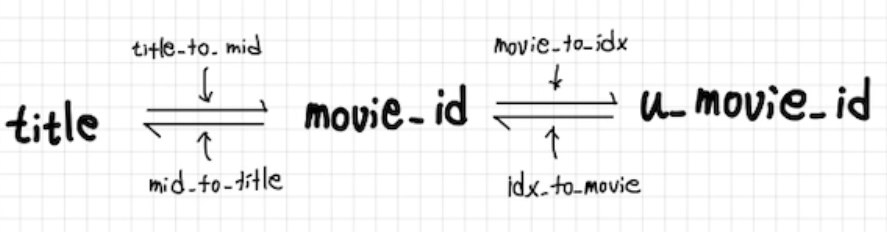

In [26]:
movie_to_idx
title_to_mid = {title : movie_id for title, movie_id in zip(movies['title'], movies['movie_id'])}
mid_to_title = {movie_id : title for title, movie_id in zip(movies['title'], movies['movie_id'])}
title_to_mid

{'Toy Story': 1,
 'Jumanji': 2,
 'Grumpier Old Men': 3,
 'Waiting to Exhale': 4,
 'Father of the Bride Part II': 5,
 'Heat': 6,
 'Sabrina': 915,
 'Tom and Huck': 8,
 'Sudden Death': 9,
 'GoldenEye': 10,
 'American President, The': 11,
 'Dracula: Dead and Loving It': 12,
 'Balto': 13,
 'Nixon': 14,
 'Cutthroat Island': 15,
 'Casino': 16,
 'Sense and Sensibility': 17,
 'Four Rooms': 18,
 'Ace Ventura: When Nature Calls': 19,
 'Money Train': 20,
 'Get Shorty': 21,
 'Copycat': 22,
 'Assassins': 23,
 'Powder': 24,
 'Leaving Las Vegas': 25,
 'Othello': 2848,
 'Now and Then': 27,
 'Persuasion': 28,
 'City of Lost Children, The': 29,
 'Shanghai Triad Yao a yao yao dao waipo qiao': 30,
 'Dangerous Minds': 31,
 'Twelve Monkeys': 32,
 'Wings of Courage': 33,
 'Babe': 34,
 'Carrington': 35,
 'Dead Man Walking': 36,
 'Across the Sea of Time': 37,
 'It Takes Two': 38,
 'Clueless': 39,
 'Cry, the Beloved Country': 40,
 'Richard III': 41,
 'Dead Presidents': 42,
 'Restoration': 43,
 'Mortal Kombat': 4

In [27]:
my_favorite_ids = [ movie_to_idx[title_to_mid[title]] for title in my_favorite.keys() ]
my_favorite_ids
my_favorite_counts = list(my_favorite.values())
my_favorite_counts

[4, 5, 3, 4, 3]

In [28]:
my_movies = pd.DataFrame({'user_id':[6039]*5, 'u_movie_id': my_favorite_ids, 'count': my_favorite_counts})
my_movies

,user_id,u_movie_id,count
0,6039,40,4
1,6039,248,5
2,6039,2106,3
3,6039,124,4
4,6039,175,3


In [29]:
# base.drop(columns='uese_id', inplace = True)
# base = base.drop(columns=['movie_id'])
# base = base.dropna()
base.tail()

,user_id,u_movie_id,count
1000203,6038,1030,3
1000205,6038,986,5
1000206,6038,311,5
1000207,6038,142,4
1000208,6038,26,4


In [30]:
if not base.isin({'user_id':[6039]})['user_id'].any():
    base = base.append(my_movies)
base = base.reset_index(drop=True)
base.user_id = base.user_id.astype(np.int64)
base.u_movie_id = base.u_movie_id.astype(np.int64)
base.tail(10)       # 잘 추가되었는지 확인해 봅시다.

,user_id,u_movie_id,count
836473,6038,1030,3
836474,6038,986,5
836475,6038,311,5
836476,6038,142,4
836477,6038,26,4
836478,6039,40,4
836479,6039,248,5
836480,6039,2106,3
836481,6039,124,4
836482,6039,175,3


---

- 위의 merge에 이어지는 내용

    - LMS 예제와는 다르게 user_id, title, count 이외에도 movie_id, time_stamp, genre, year를 추가해주어야 한다
    - [Trouble] DataFrame을 concat할때 index번호가 다르면 가로방향 concat이 이루어지지 않는다
      - [Shoot] reset_index(drop=True)를 통해 해결할 수 있다

In [ ]:
# import datetime
# my_movies = pd.DataFrame()
# for movie, score in my_favorite.items() :
#     time = datetime.datetime.now()
# #     print(data['title'].str.contains(movie))
#     temp = pd.DataFrame([[6041, movie, score, time]], columns = ['user_id', 'title', 'count', 'timestamp']).reset_index(drop=True)
#     temp2 = data[data['title'].str.contains(movie)].iloc[[0]][['movie_id', 'genre', 'year']].reset_index(drop=True)
#     my_movies = my_movies.append(pd.concat([temp, temp2], axis=1))

---

# 3. 모델 학습
## CSR matrix
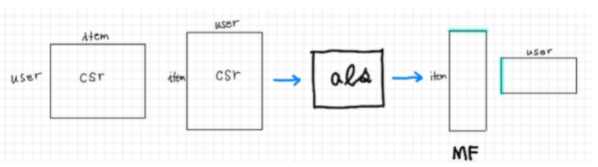

In [31]:
from scipy.sparse import csr_matrix

- [Trouble] ValueError: column index exceeds matrix dimensions
  - csr_matrix는 항상 입력으로 들어가는 데이터의 최대값 보다 shape가 1 더 커야 한다
  - unique를 기준으로 판단해야 할 것 같은데 왜 max를 기준으로 판단하지 ?
  - 만약 그렇다고 하더라도 왜 max보다 1개 더 큰 값이 필요하지 ?
  - [Shoot] ratings 데이터에 들어있는 user와 item값을 unique하고 연속적인 값으로 변환 후 문제가 없어졌다!

In [34]:
num_movies = base['u_movie_id'].nunique()
num_user = base['user_id'].nunique()
print(num_movies, base['u_movie_id'].max())
print(num_user, base['user_id'].max())

3628 3627
6040 6039


In [35]:
# csr_base = csr_matrix((base['count'], (base['movie_id'], base['user_id'])), shape = ( max(num_movies,base['movie_id'].max())+1, max(num_user, base['user_id'].max())+1))
# csr_base = csr_matrix((base['count'], (base['movie_id'], base['user_id'])), shape = ( 3953,6042 ) )
# csr_base = csr_matrix((base['count'], (base['user_id'], base['movie_id'])), shape = (num_user, num_movies))
csr_base = csr_matrix((base['count'], (base['u_movie_id'], base['user_id'])), shape = (num_movies , num_user))
# csr_data = csr_matrix((data.play, (data.user_id, data.artist)), shape= (num_user, num_artist))

## 훈련

In [36]:
from implicit.als import AlternatingLeastSquares
import os
import numpy as np

os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

In [37]:
# Implicit AlternatingLeastSquares 모델의 선언
als_model = AlternatingLeastSquares(factors=100, regularization=0.01, use_gpu=False, iterations=15, dtype=np.float32)

In [38]:
# 모델 훈련
als_model.fit(csr_base)

  0%|          | 0/15 [00:00<?, ?it/s]

In [39]:
als_model.user_factors.shape, als_model.item_factors.shape

((6040, 100), (3628, 100))

# 4. 모델 적용
## 모델이 예측한 나의 선호도: 기존 영화, 새로운 영화

In [62]:
TH = 6039
th_vector = als_model.user_factors[TH]

for movie in my_favorite.keys():
    movie_id = movie_to_idx[title_to_mid[movie]]
    movie_vector = als_model.item_factors[movie_id]
    print(f'{movie} 선호도: {np.dot(th_vector, movie_vector)}')

Toy Story 선호도: 0.4262792766094208
Good Will Hunting 선호도: 0.37390100955963135
Phantom of the Opera, The 선호도: 0.04768069460988045
Matrix, The 선호도: 0.44835054874420166
Men in Black 선호도: 0.39883187413215637


- [추측] 예상하건대, 협업필터링에서 선호도는 user의 선호분포뿐 아니라 item에 대한 선호분포도 반영하는 것 같다. Good Will Hunting에 최고점을 주었음에도 선호도가 0.37에 그쳤다.
- 아이템에 대한 선호도 분포를 그려보자. Good Will Hunting과 Toy Story에 대한 평균 평점은 4.3점 정도이다. Matrix에 대한 평균 평점은 4.5점 정도이다.
- 만일 **컨텐츠 기반 필터링**을 사용했다면 나의 평점과 비례하는 선호도가 나왔겠지만, als 모델은 **협업 필터링** 모델로 5점을 준 Good Will Hunting 보다 Toy Story(4)와 Matrix(4)가 더 높은 선호도를 보이게 할 수도 있지 않았을까 추측해본다.

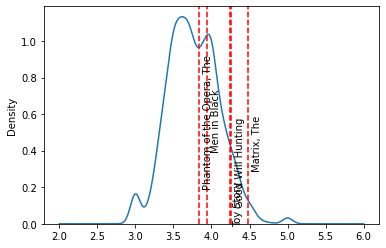

In [61]:
import matplotlib.pyplot as plt
base.groupby('u_movie_id')['count'].mean().plot.density()
# movie_to_idx[title_to_mid['Good Will Hunting']]
GWH_index = movie_to_idx[title_to_mid['Good Will Hunting']]
plt.ylim(bottom=0)
for idx, movie in enumerate(my_favorite.keys()):
    movie_index = movie_to_idx[title_to_mid[movie]]
    plt.axvline(base.groupby('u_movie_id')['count'].mean()[movie_index], ls='--',c='red')
    plt.text(base.groupby('u_movie_id')['count'].mean()[movie_index]+0.05, idx/10, movie, rotation = 'vertical')

plt.show()

In [63]:
movie = ['Sleepless in Seattle', 'Forrest Gump'][-1]
movie_id = movie_to_idx[title_to_mid[movie]]
movie_vector = als_model.item_factors[movie_id]
np.dot(th_vector, movie_vector)

0.18960185

## 추천받기
### 내가 좋아하는 영화와 비슷한 영화: similar items

- 실제로 내가 좋아하던 영화 Shawshank Redemption, Truman show와 Jerry Maguire가 포함되어 있다!!

In [64]:
def get_similar_movie(movie: str):
    movie_id = movie_to_idx[title_to_mid[movie]]
    similar_movies = als_model.similar_items(movie_id)
    similar_movies = [ mid_to_title[idx_to_movie[movie[0]]] for movie in similar_movies ]
    return similar_movies

In [65]:
get_similar_movie('Good Will Hunting')

['Good Will Hunting',
 'Shawshank Redemption, The',
 'Apollo 13',
 'Truman Show, The',
 'Dead Man Walking',
 'Pulp Fiction',
 'Awakenings',
 'Silence of the Lambs, The',
 'Quiz Show',
 'Trainspotting']

### 내가 가장 좋아할 만한 영화: recommend

- 버그로 인해 여전히 filter_already_liked_items는 작동하지 않았지만, 의미있는 추천을 하고 있는 것을 볼 수 있다.
- 실제로 Teminator, Braveheart, Silence of the Lambs, Shawshank Redemption, Total Recall등 필자가 이미 본 영화들이 다수 포함되어 있다.

In [66]:
artist_recommended = als_model.recommend(TH, csr_base.T, N=20, filter_already_liked_items=True)
artist_recommended
[ mid_to_title[idx_to_movie[movie[0]]] for movie in artist_recommended ]

['Matrix, The',
 'Terminator 2: Judgment Day',
 'Toy Story',
 'Men in Black',
 'Jurassic Park',
 'Good Will Hunting',
 'Toy Story 2',
 'Saving Private Ryan',
 'Silence of the Lambs, The',
 'Fugitive, The',
 "Bug's Life, A",
 'Braveheart',
 'Shawshank Redemption, The',
 'Total Recall',
 'Twelve Monkeys',
 'Groundhog Day',
 'Apollo 13',
 'Back to the Future',
 'Sixth Sense, The',
 "Schindler's List"]

In [67]:
u_movie_id = movie_to_idx[title_to_mid['Shawshank Redemption, The']]
explain = als_model.explain(TH, csr_base.T, itemid=u_movie_id)
explain
[(mid_to_title[idx_to_movie[i[0]]], i[1]) for i in explain[1]]

[('Good Will Hunting', 0.21248294878762308),
 ('Toy Story', 0.022398536768911226),
 ('Matrix, The', 0.01596719770100346),
 ('Phantom of the Opera, The', 0.002171231117624808),
 ('Men in Black', 0.000771566698250845)]

# 회고
- 요즘에 가장 관심이 많이가는 분야는 추천시스템이다. 그 추천시스템을 다룬 첫 프로젝트여서 굉장히 감명깊었다.
- CV보다 더 추상적이고, 도메인 지식이 많이 필요한 분야이지만, 그만큼 데이터 분석과 딥러닝이 결합될 수 있는 분야라는 생각이 든다.
- 해당 노드에서 MF, CSR, ALS모델 등추천시스템에 대한 기본적인 지식들을 맛볼 수 있었다.
- 그러나 CV분야와 다르게 모델에 대한 심도 있는 이해가 없다면 결과를 전혀 해석할 수 없음을 알 수 있었다.
- 이에 따라 더 많은 수학적, 이론적 학습에 대한 필요와 욕구를 느꼈다.
- 추천시스템과 이론적 배경에 대한 학습을 병행하면서 xAI를 다루는 데이터 과학자가 되고 싶다는 생각을 한다.
- 또한 이 추천시스템을 교육적 목적으로 사용할 수 있다면 삶의 질 향상에 큰 기여를 할 수 있을 것 같다는 생각을 했다. 구체적으로 어떻게 할 수 있을지는 더 많은 공부가 필요할 것 같다.